* [A/B testing - Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing)
* [renatofillinich/ab_test_guide_in_python](https://github.com/renatofillinich/ab_test_guide_in_python)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [2]:
df = pd.read_csv("data/ab_data.csv")
df.shape

(294478, 5)

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [7]:
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

In [8]:
session_counts = df["user_id"].value_counts(ascending=False)
session_counts

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64

In [9]:
multi_users = session_counts[session_counts > 1].count()
multi_users

3894

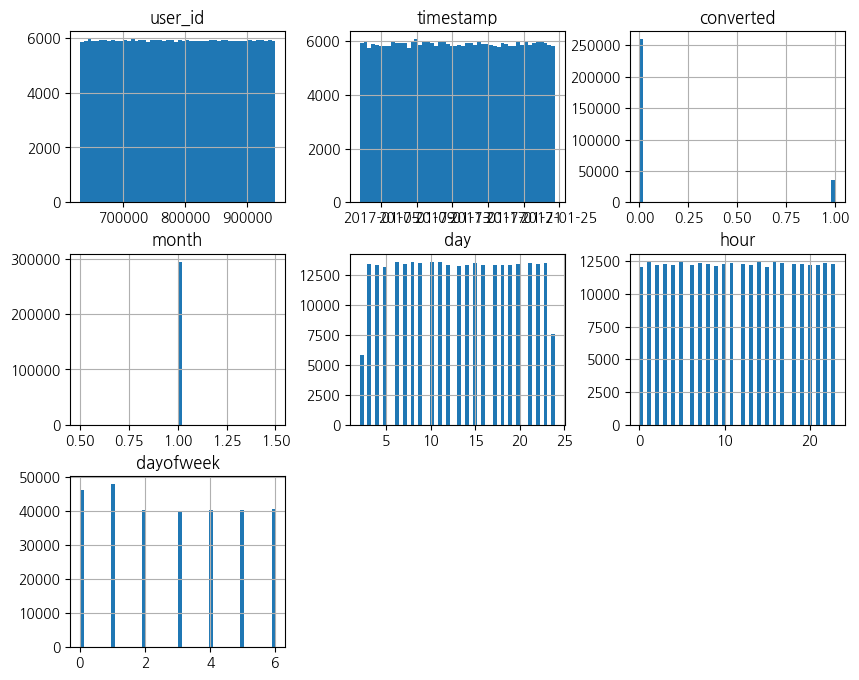

In [10]:
_ = df.hist(bins=50, figsize=(10, 8))

<AxesSubplot: xlabel='landing_page', ylabel='count'>

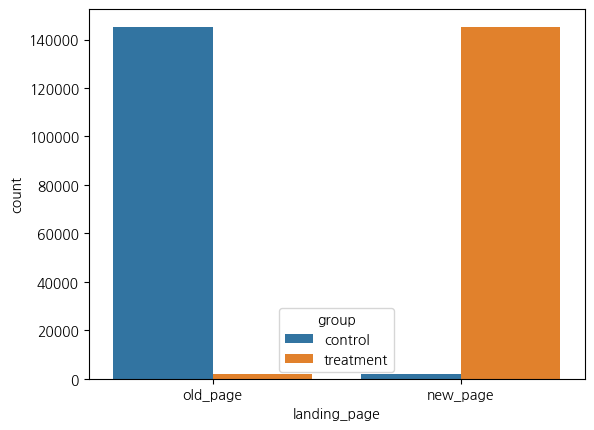

In [11]:
sns.countplot(data=df, x="landing_page", hue="group")

In [12]:
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


<AxesSubplot: >

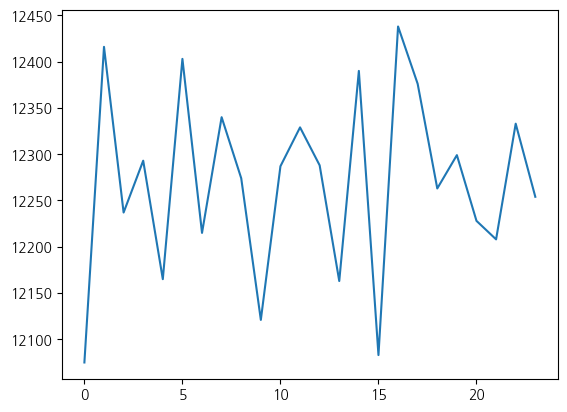

In [13]:
df["hour"].value_counts().sort_index().plot()

<AxesSubplot: >

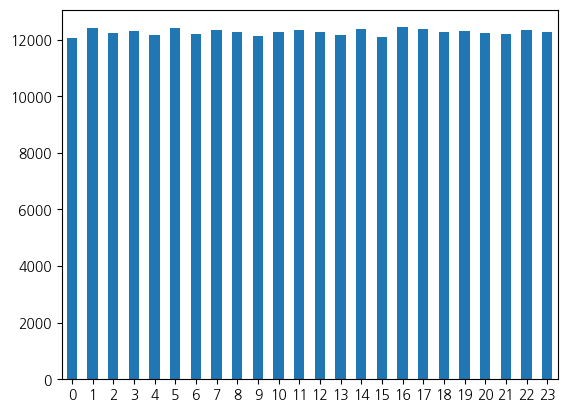

In [14]:
df["hour"].value_counts().sort_index().plot.bar(rot=0)

<AxesSubplot: >

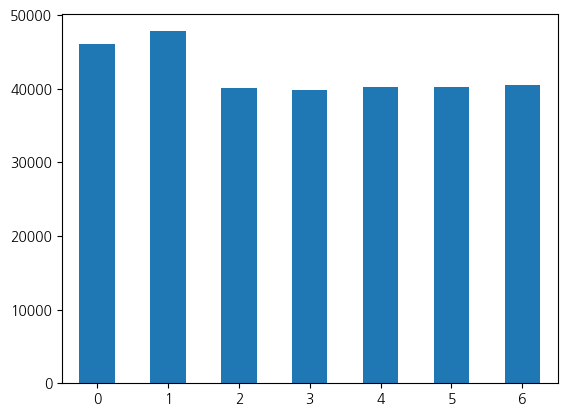

In [15]:
df["dayofweek"].value_counts().sort_index().plot.bar(rot=0)

In [16]:
hwd = pd.crosstab(df["hour"], df["dayofweek"])
hwd.columns = [w for w in "월화수목금토일"]
hwd

,월,화,수,목,금,토,일
hour,,,,,,,
0,1667,2205,1612,1726,1637,1647,1581
1,1750,2307,1668,1681,1663,1671,1676
2,1718,2276,1631,1635,1710,1667,1600
3,1697,2230,1663,1663,1692,1668,1680
4,1652,2231,1660,1592,1680,1688,1662
5,1683,2278,1620,1689,1720,1722,1691
6,1602,2236,1673,1661,1662,1693,1688
7,1687,2213,1684,1689,1654,1671,1742
8,1699,2245,1641,1657,1706,1637,1689


<AxesSubplot: ylabel='hour'>

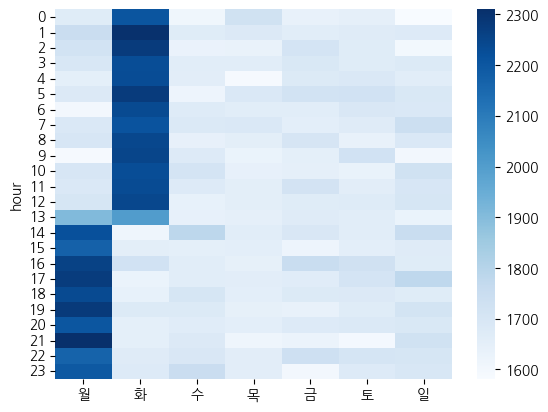

In [17]:
sns.heatmap(hwd, cmap="Blues")

<AxesSubplot: xlabel='hour'>

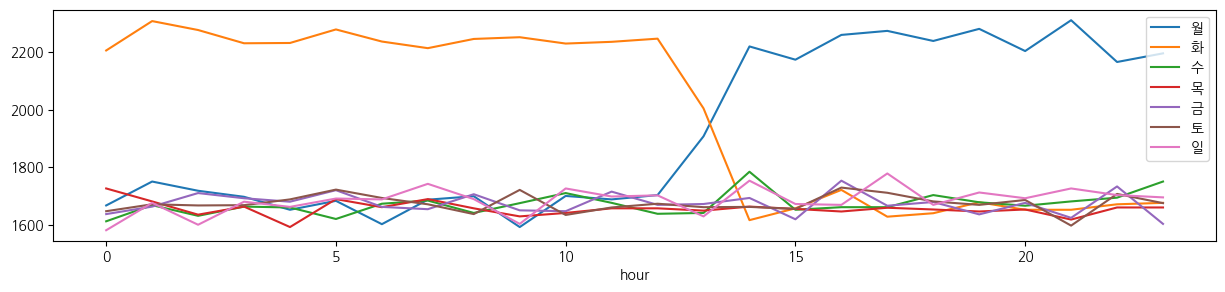

In [18]:
hwd.plot(figsize=(15, 3))

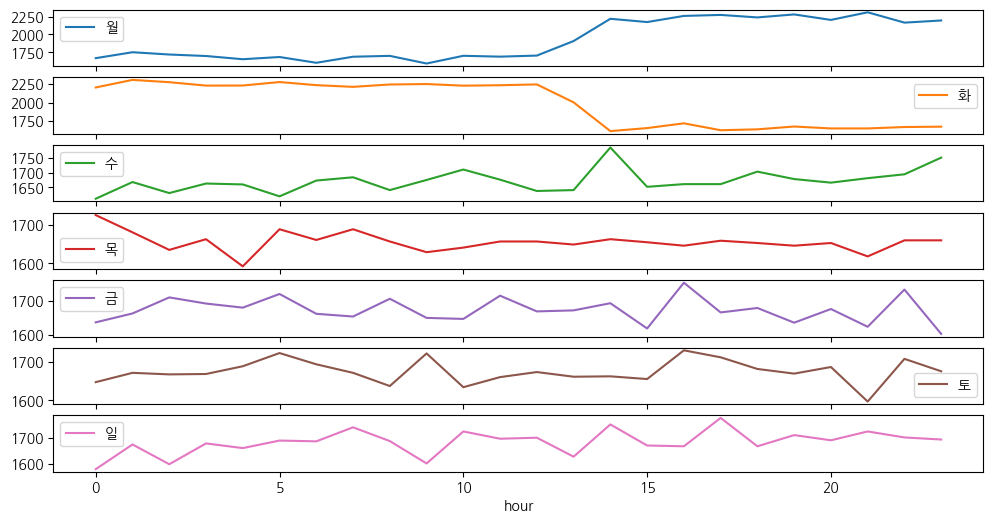

In [19]:
_ = hwd.plot(subplots=True, figsize=(12, 6))

<AxesSubplot: xlabel='hour'>

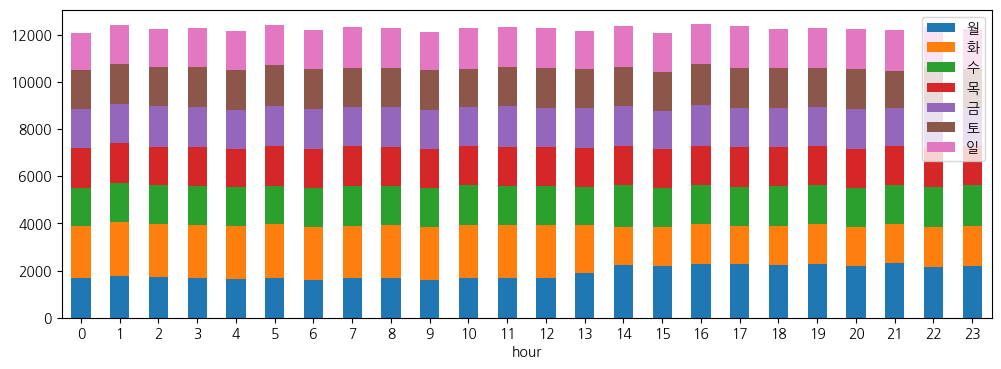

In [20]:
hwd.plot.bar(stacked=True, figsize=(12, 4), rot=0)

<AxesSubplot: xlabel='hour', ylabel='count'>

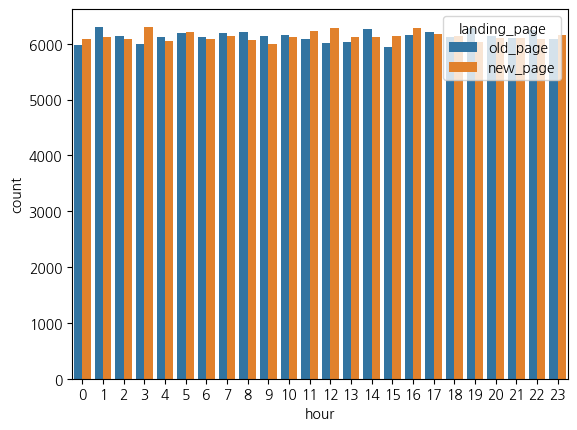

In [21]:
sns.countplot(data=df, x="hour", hue="landing_page")

<AxesSubplot: xlabel='dayofweek', ylabel='count'>

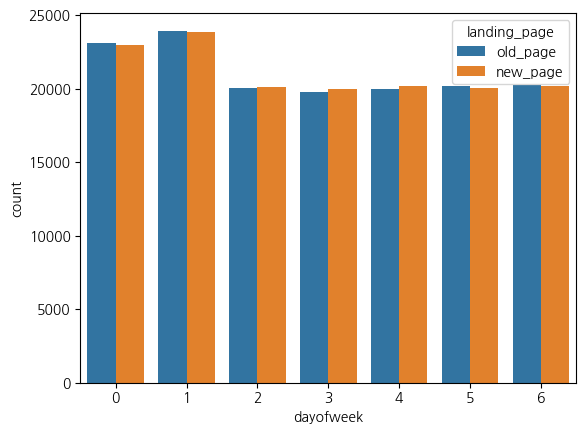

In [22]:
sns.countplot(data=df, x="dayofweek", hue="landing_page")

<AxesSubplot: xlabel='day', ylabel='count'>

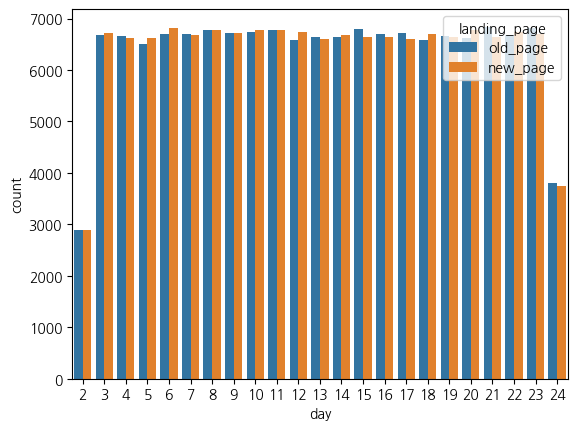

In [23]:
sns.countplot(data=df, x="day", hue="landing_page")

In [24]:
conversion_rates = df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001
